# Spectral Extension

> We will use the terms "drone", "UAV" (Unmanned Aerial Vehicle) and "UAS" (Unmanned Aircraft System) interchangeably

This notebook demonstrates how to obtain high-resolution (0.125m) Sentinel-2 bands by combining a Sentinel-2 product with RGB drone imagery.

The generated multispectral images cover the following 8 Sentinel-2 bands:
| Spectral Band | Band | Wavelength (nm) |
|-----|-----|-----|
| Blue	| B2 | 492 $\pm$ 66 |
| Green | B3| 559 $\pm$ 36 |
| Red | B4 | 665 $\pm$ 31 |
| Vegetation red edge | B5 | 704 $\pm$ 15 |
| Vegetation red edge | B6 | 740 $\pm$ 15 |
| Vegetation red edge | B7 | 781 $\pm$ 20 |
| NIR | B8 | 833 $\pm$ 106 |
| NNIR | B8a | 864 $\pm$ 21 |


The model was trained on agriculture-related images, more specifically cover crop images in the Maryland regions, but can be applied to other regions and crops.

The model used in this workflow is based on the paper "Complementarity of UAS and satellite imagery for predicting cover crop biomass and nitrogen at scale", by Arif Masrur (Penn State), Paul R. Adler (USDA) and Peder Olsen (Microsoft Research, RFI) submitted to Journal of "Remote Sensing and the Environment" in 2024.

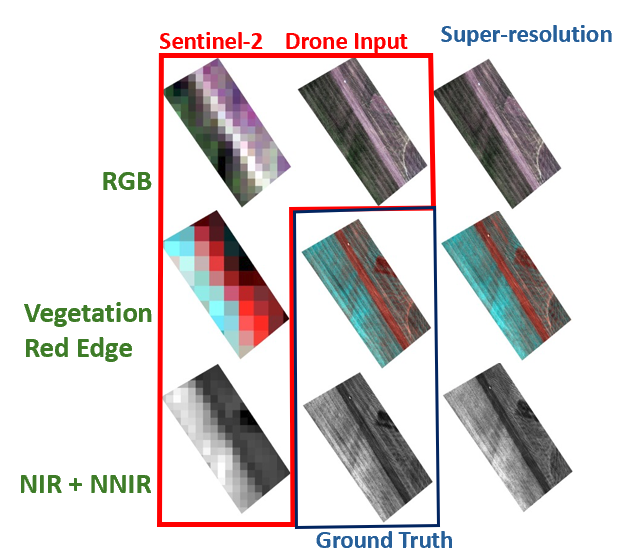

## Input Image
The input image to the workflow is expected to be an RGB (3-band) image, with bands in the 0-255 range.
In case your image is available in a different resolution, we provide a function to resample it to the correct resolution in the notebook that you can use.

## Environment setup

Before running this notebook, make sure to install all the required dependencies.
You may set up a micromamba environment with all the required dependencies for FarmVibes.AI as shown below.

```bash
$ micromamba env create -f ../env.yaml
$ micromamba activate farmvibes-ai
```

## Imports

In [ ]:
import time
from datetime import datetime
from typing import Any, List, Optional, Tuple

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from numpy.typing import NDArray
from rasterio.warp import Resampling, calculate_default_transform, reproject
from shapely import geometry as shpg

from vibe_core.client import get_default_vibe_client
from vibe_core.data import ExternalReference, gen_guid

## Helper functions

We provide a function to save a resampled raster in the correct resolution, with the chosen RGB bands.

In [ ]:
def resample_uav_raster(
    input_filepath: str,
    output_filepath: str,
    nodata: int = 0,
    bands: Tuple[int, int, int] = (0, 1, 2),
    resampling: Resampling = Resampling.nearest,
):
    """
    Resample input raster to .125m resolution
    """
    t0 = time.perf_counter()
    with rasterio.open(input_filepath) as src:
        left, bottom, right, top = src.bounds
        dst_transform, dst_width, dst_height = calculate_default_transform(
            src_crs=src.crs,
            dst_crs=src.crs,
            width=src.width,
            height=src.height,
            left=left,
            bottom=bottom,
            right=right,
            top=top,
            # Model resolution
            resolution=0.125,
        )
        profile = src.profile
        profile["width"] = dst_width
        profile["height"] = dst_height
        profile["transform"] = dst_transform
        profile["nodata"] = nodata
        profile["count"] = len(bands)
        with rasterio.open(output_filepath, "w", **profile) as dst:
            # Reproject each band, one at a time
            for i, b in enumerate(bands):
                ti0 = time.perf_counter()
                reproject(
                    rasterio.band(src, b + 1),
                    destination=rasterio.band(dst, i + 1),
                    resampling=resampling,
                )
                ti1 = time.perf_counter()
                print(f"Finished band {b} in {ti1 - ti0:.2f}s")
        print(f"Finished raster in {time.perf_counter() - t0:.2f}s")


def to_img(
    x: NDArray[Any],
    percentile: Tuple[float, float] = (0.5, 99.5),
    gamma: float = 1.0,
    bands: Optional[List[int]] = None,
):
    """
    Normalize bands to 0-255 range.
    """
    img = x[bands] if bands is not None else x
    img = img.transpose([1, 2, 0])
    plow, phigh = np.percentile(img, percentile, axis=(0, 1))
    img = np.clip(img, plow, phigh)
    img = (img - plow) / (phigh - plow)
    if gamma != 1:
        img = img**gamma
    return (img * 255).clip(0, 255).astype(np.uint8)

## Spectral extension workflow

The spectral extension workflow will download the required Sentinel-2 product, resample it to the input raster grid, and run the spectral extension model.
For best results, it's important that the Sentinel-2 product is cloud-free, so the drone image should be taken on a day with blue skies.

## Building the workflow input

The workflow input should be a reference to an external facing url, such as a SAS-signed blob storage url.

**Make sure the input image is in the required format**: 0.125m/px resolution, and 0-255 pixel range.

In [ ]:
# Change this varialbe to the url with the UAV Raster file, such as SAS-signed blob url
uav_url = "URL HERE"

In [ ]:
# Define the geometry of the input according to the Raster bounds
with rasterio.open(uav_url) as src:
    geom = gpd.GeoSeries(shpg.box(*src.bounds), crs=src.crs).to_crs("epsg:4326").iloc[0]
# Define the date for which to get the Sentinel-2 image
time_range = (datetime(2020, 6, 3), datetime(2020, 6, 3))

# Create the workflow input
raster_ref = ExternalReference(
    id=gen_guid(),
    time_range=time_range,
    geometry=shpg.mapping(geom),
    assets=[],
    url=uav_url,
)

In [ ]:
# Instantiate a client to run workflows in the cluster
client = get_default_vibe_client("local")
# Submit a run for the spectral extension workflow with our input
run = client.run(
    "ml/spectral_extension", "Spectral Extension workflow", input_data={"raster": raster_ref}
)

In [ ]:
# Check the status of the workflow as it is running
run.monitor()

## Workflow outputs
After the workflow is done, the outputs can be accessed via the `run.output` variable, which is a dictionary.
There are three keys:
- `s2_rasters`: the original Sentinel-2 product used in the workflow;
- `matched_raster`: the Sentinel-2 product resampled to the same grid as the UAV image;
- `extended_raster`: the generated raster with 8 Sentinel-2 bands in high-resolution.

Below we check some metadata from each file

In [ ]:
with rasterio.open(uav_url) as src:
    print("UAV image")
    print(f"CRS: {src.crs}, height: {src.height}, width: {src.width}, resolution: {src.res}")
    uav_geom = shpg.box(*src.bounds)
with rasterio.open(run.output["s2_rasters"][0].raster_asset.url) as src:
    print("Sentinel-2 product")
    print(f"CRS: {src.crs}, height: {src.height}, width: {src.width}, resolution: {src.res}")
    s2_geom = shpg.box(*src.bounds)
with rasterio.open(run.output["matched_raster"][0].raster_asset.url) as src:
    print("Resampled Sentinel-2 product")
    print(f"CRS: {src.crs}, height: {src.height}, width: {src.width}, resolution: {src.res}")
    resampled_geom = shpg.box(*src.bounds)
with rasterio.open(run.output["extended_raster"][0].raster_asset.url) as src:
    print("Generated raster")
    print(f"CRS: {src.crs}, height: {src.height}, width: {src.width}, resolution: {src.res}")
    extended_geom = shpg.box(*src.bounds)

## Plot results

Let's read the rasters, normalize them for visualization, and plot them side-by-side

In [ ]:
# Slice the image to zoom in a specific area, choose this according to your image
ys = slice(4000,6000)
xs = slice(6000, 8000)

# Load the original UAV data
with rasterio.open(uav_url) as src:
    uav_ar = src.read()
# Normalize the image for visualization
uav_img = to_img(uav_ar, percentile=(0.5, 99.5), gamma=1.0, bands = [0, 1, 2])[ys, xs]
del uav_ar  # Delete unnormalized raster to free memory

# Load the resampled (low-resolution) Sentinel-2 product
with rasterio.open(run.output["matched_raster"][0].raster_asset.url) as src:
    match_ar = src.read()
# Normalize the image for visualization
s2_img = to_img(match_ar, percentile=(0.5, 99.5), gamma=0.7)[ys, xs]
del match_ar
s2_rgb_img = s2_img[..., [3, 2, 1]]
s2_vre_img = s2_img[..., [4, 5, 6]]
s2_nir_img = s2_img[..., [7, 7, 8]]

# Load the generated image with 8 bands
with rasterio.open(run.output["extended_raster"][0].raster_asset.path_or_url) as src:
    ex_ar = src.read()
# Normalize the image for visualization
pred_img = to_img(ex_ar, percentile=(0.5, 99.5), gamma=1.0)[ys, xs]
del ex_ar
pred_rgb_img = pred_img[..., [2, 1, 0]]
pred_vre_img = pred_img[..., [3, 4, 5]]
pred_nir_img = pred_img[..., [6, 6, 7]]

# Plot images for comparison
fig, ax = plt.subplots(3, 3, figsize=(12,12))
ax1, ax2, ax3 = ax[0]
ax1.imshow(pred_rgb_img)
ax1.set_title('Spectral-SRCNN RGB', fontsize=9)
ax2.imshow(pred_vre_img)
ax2.set_title('Spectral-SRCNN Red Edge', fontsize=9)
ax3.imshow(pred_nir_img)
ax3.set_title('Spectral-SRCNN NIR', fontsize=9)

ax1, ax2, ax3 = ax[2]
ax1.imshow(s2_rgb_img)
ax1.set_title('Sentinel-2 RGB', fontsize=9)
ax2.imshow(s2_vre_img)
ax2.set_title('Sentinel-2 Red Edge', fontsize=9)
ax3.imshow(s2_nir_img)
ax3.set_title('Sentinel-2 NIR', fontsize=9)

ax1, ax2, ax3 = ax[1]
ax1.imshow(uav_img)
ax1.set_title('UAS RGB', fontsize=9)

for axi in ax:
    for axij in axi:
        axij.axis(False)
plt.tight_layout()
plt.show()

## Example result:
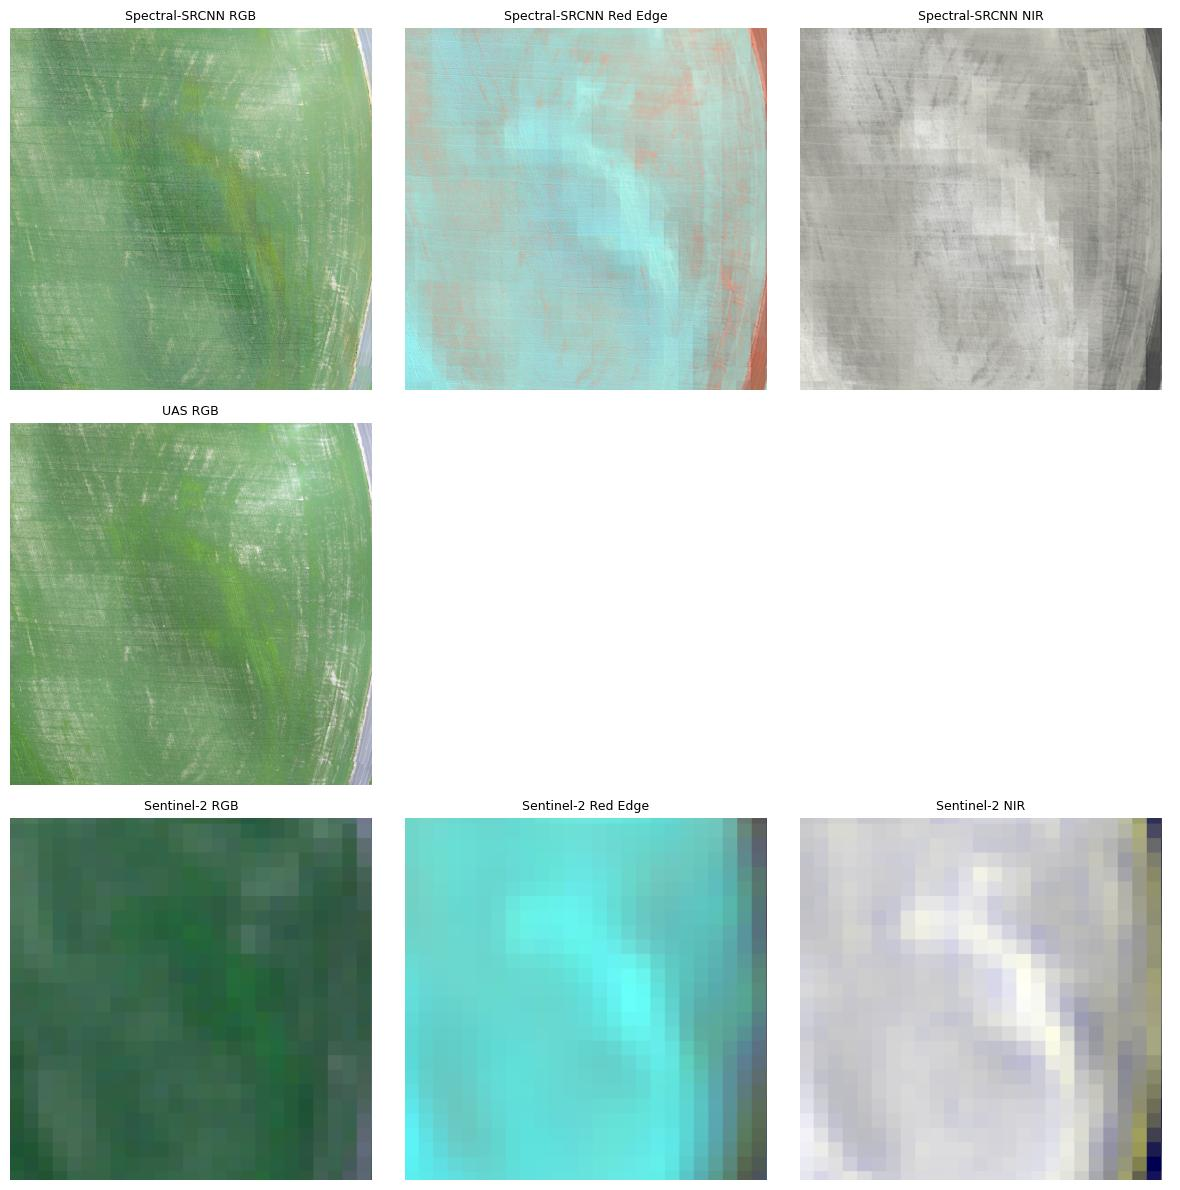